### 1)Reading and exploring the dataset

In [1]:
import pandas as pd
amzn=pd.read_csv('ratings_Electronics.csv',names=['userID','productID','ratings','timestamp'])
amzn.head()

,userID,productID,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [2]:
print("The dataset has about {} rows".format(amzn.shape[0]))
print("The dataset has about {} columns".format(amzn.shape[1]))

The dataset has about 7824482 rows
The dataset has about 4 columns


In [3]:
amzn.dtypes

userID        object
productID     object
ratings      float64
timestamp      int64
dtype: object

userID seems to be ok as an object but since the product ID seems to have only numbers(atleast at the start) it shouldn't be an object.Let's check it out for irrelevancies.

In [4]:
amzn['productID'].unique()

array(['0132793040', '0321732944', '0439886341', ..., 'BT008T2BGK',
       'BT008UKTMW', 'BT008V9J9U'], dtype=object)

So it seems that we've strings or alphabets as well hence the productID seems to be fine.

In [5]:
amzn.isnull().sum()

userID       0
productID    0
ratings      0
timestamp    0
dtype: int64

So this  confirms  the absence of any null values in the dataset.

In [6]:
amzn.eq("?").any()

D:\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


userID       False
productID    False
ratings      False
timestamp    False
dtype: bool

In [7]:
amzn.describe()

,ratings,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


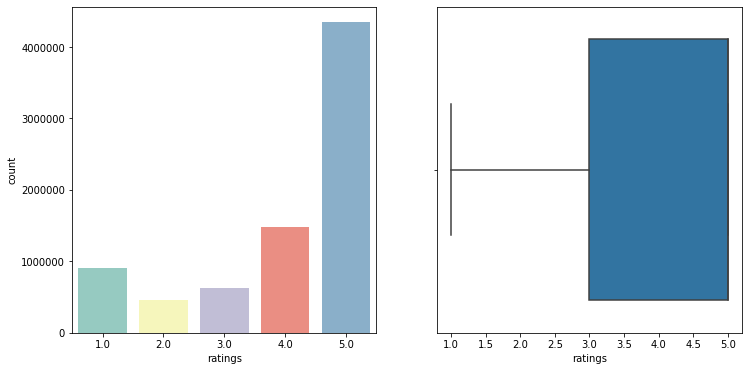

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2, figsize=(12,6))
sns.countplot(amzn['ratings'],palette='Set3',ax = ax[0])
sns.boxplot(data=amzn,x='ratings',ax = ax[1])
fig.show()

As per the above plots it's quite clear that a rating of 5 has been given the max time but all in all there doesn't seem to be an outlier as well the data is mostly concentrated between a rating of 3-5 or in other words the products that are available are either the products with a higher rating or only the products which have higher rating are being available.So data for low ratings should have been available to get an exact view of the products range.

## 2)Take a subset of the data to make it less sparse/denser(Keeping the users who have given a rating for a minimum of 50 products)

In [12]:
subs=amzn['userID'].value_counts()
amzn=amzn[amzn.userID.isin(subs[subs>=50].index)]

In [13]:
amzn.shape

(125871, 4)

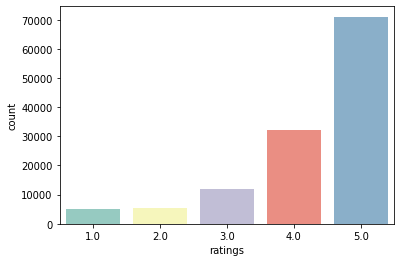

In [14]:
sns.countplot(amzn['ratings'],palette='Set3')

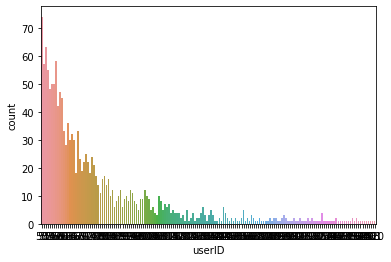

In [15]:
sns.countplot(amzn['userID'].value_counts())

## 3)Splitting the data randomly into train & test with a split ratio of 70:30

In [16]:
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
reader=Reader(rating_scale=(1,5))
data = Dataset.load_from_df(amzn[['userID','productID', 'ratings']],reader)
train,test=train_test_split(data,test_size=0.15,random_state=456788)

## 4)Building popularity recommender model

In [17]:
amzn.groupby('productID')['ratings'].mean().sort_values(ascending=False)

productID
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
             ... 
B000VJ0YQ0    1.0
B000MVEBOS    1.0
B000C0OF54    1.0
B005YXXT7Y    1.0
B0080REM4A    1.0
Name: ratings, Length: 48190, dtype: float64

In [18]:
product_mean_count=pd.DataFrame(amzn.groupby('productID')['ratings'].mean().sort_values(ascending=False))

In [19]:
product_mean_count

,ratings
productID,
B00LKG1MC8,5.0
B002QUZM3M,5.0
B002QWNZHU,5.0
B002QXZPFE,5.0
B002R0DWNS,5.0
...,...
B000VJ0YQ0,1.0
B000MVEBOS,1.0
B000C0OF54,1.0


In [20]:
product_mean_count['ratings_count']=pd.DataFrame(amzn.groupby('productID')['ratings'].count().sort_values(ascending=False))
product_mean_count.shape

(48190, 2)

In [21]:
print("The following are the top 10 popular electronic items ")
product_mean_count.sort_values(by='ratings_count',ascending=False).head(10)

The following are the top 10 popular electronic items 


,ratings,ratings_count
productID,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149
B008DWCRQW,4.094891,137
B00829THK0,4.416058,137
B002R5AM7C,4.125000,128
B004CLYEDC,4.669492,118


## 5) Building collaborative filtering model

In [22]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import accuracy
import collections

In [23]:
#user based collaborative filtering model
kwm=KNNWithMeans(k=50)
svd=SVD()

In [24]:
#fitting the model
kwm.fit(train)
svd.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [26]:
#predicting for the KWithMeans model
test_pred=kwm.test(test)
#predicting for the SVD model
test_pred1=svd.test(test)

## 6)Evaluating the collab model(made on 2 different  algorithms KWithMeans & SVD)

In [27]:
print("The accuracy of the model built using KWithMeans is : ")
accuracy.rmse(test_pred)
print("The accuracy of the model built using SVD is : ")
accuracy.rmse(test_pred1)

The accuracy of the model built using KWithMeans is : 
RMSE: 1.0541
The accuracy of the model built using SVD is : 
RMSE: 0.9774


0.9774223035613632

In [28]:
def get_top_n(predictions, n):                
    # First map the predictions to each user.
    top_n = collections.defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [29]:
#Getting top n using K with means model
top_n = get_top_n(test_pred, n=5)

In [30]:
#Getting top n using SVD model
top_n1 = get_top_n(test_pred1,n=5)

In [31]:
top_n

defaultdict(list,
            {'A1MZL91Z44RN06': [('B004C4SHQY', 5),
              ('B00766BF1E', 5),
              ('B002V8C3W2', 5),
              ('B00GMGDH38', 4.99564492626664),
              ('B0074FGLUM', 4.9908995764872195)],
             'A25QJBK33C4O0R': [('B009RPDP2Y', 4.665161892901619),
              ('B00BGA9WK2', 4.498816540062146),
              ('B002QC17VG', 4.494313093351911),
              ('B0018KSPDK', 4.413394216133941),
              ('B00BOHNYU6', 4.371304778995436)],
             'A240FRPD4MEXND': [('B00A7PPLP2', 4.586479097930392),
              ('B001DJ9GOS', 4.463259175240423),
              ('B004I5BUSO', 4.434378558422705),
              ('B00KIMX4EY', 4.402749449494786),
              ('B001DJ7Y2O', 4.3225620434105565)],
             'A2Z2MUP8JRJXEU': [('B000ID7QNI', 5),
              ('B0007DDK7A', 4.800151202103183),
              ('B0030B2O3M', 4.63265306122449),
              ('B005HSG3TC', 4.163540903600879)],
             'AQB4DH57MSZSC': [('B0077K

In [32]:
top_n1

defaultdict(list,
            {'A1MZL91Z44RN06': [('B00E87E1OM', 4.993716886422442),
              ('B004CLYEFK', 4.942826526735921),
              ('B002V8C3W2', 4.930521423077081),
              ('B0074FGLUM', 4.862218442279612),
              ('B00006HSYC', 4.846174736004606)],
             'A25QJBK33C4O0R': [('B00BOHNYU6', 4.294632976024157),
              ('B00FFJ0HUE', 4.214649502465633),
              ('B004CLYEE6', 4.101425453510934),
              ('B009RPDP2Y', 4.037280572765624),
              ('B00CFGVGNM', 4.004949647056354)],
             'A240FRPD4MEXND': [('B00KIMX4EY', 4.651165814365643),
              ('B0063705PE', 4.503410963884027),
              ('B00A7PPLP2', 4.497490664095892),
              ('B001DJ9GOS', 4.448498967665852),
              ('B001DJ7Y2O', 4.399378322166308)],
             'A2Z2MUP8JRJXEU': [('B000ID7QNI', 5),
              ('B0007DDK7A', 4.825255111238711),
              ('B0030B2O3M', 4.464295281070607),
              ('B005HSG3TC', 4.4016765652

## 7)Getting the top - 5 recommendations for each user

In [33]:
# Print the recommended items for each user based on the K with means model
print("The following are the top-5 recommended products for each user")
for uid, est in top_n.items():
    print(uid, [iid for (iid, _) in est])

The following are the top-5 recommended products for each user
A1MZL91Z44RN06 ['B004C4SHQY', 'B00766BF1E', 'B002V8C3W2', 'B00GMGDH38', 'B0074FGLUM']
A25QJBK33C4O0R ['B009RPDP2Y', 'B00BGA9WK2', 'B002QC17VG', 'B0018KSPDK', 'B00BOHNYU6']
A240FRPD4MEXND ['B00A7PPLP2', 'B001DJ9GOS', 'B004I5BUSO', 'B00KIMX4EY', 'B001DJ7Y2O']
A2Z2MUP8JRJXEU ['B000ID7QNI', 'B0007DDK7A', 'B0030B2O3M', 'B005HSG3TC']
AQB4DH57MSZSC ['B0077KMY4G', 'B009NHWVIA', 'B002MCZJ78', 'B007PTCFFW', 'B00884WH74']
A27TN8D0CZ8LUY ['B004SD1ZPY', 'B0015YU0FA', 'B00G2KM5QO', 'B0021AG04C', 'B00083Y82K']
A18U49406IPPIJ ['B000CKVOOY', 'B00GTLN1BO', 'B00FLKW0JI', 'B00JQTNVL6', 'B00AV3XJOU']
A23ONMGKEWDG4M ['B001BN55AK', 'B005I03WOI', 'B000AZ57M6', 'B002WE6D44', 'B00425GCTC']
A2NX6MFZP8TM6S ['B000AYJDD6', 'B00006HSML', 'B003LSTD38', 'B0007NWM0Q', 'B002R5AM7C']
A1U5IJHJK84S54 ['B005LDLP8W', 'B008N6FM7E', 'B0058OGZIY', 'B009RVLX1S', 'B001P7TDKU']
A2EN82VBJT44QP ['B002SFDJMQ', 'B0043GT9Y0', 'B004265KQM', 'B00E055H5O', 'B005D6C14Y']
AQM0K7

A185O1MX1RP964 ['B000EIXWPI', 'B000EUFJXE', 'B008AEBY1M', 'B003M76AFC', 'B005KLJBE0']
A26CPEEWB2WKRE ['B000B9O83A', 'B005OA3BSY', 'B000050FGQ', 'B0015WJA30', 'B00009R6P6']
A1VTCSCH8FFC76 ['B001NOJO4U', 'B003D3NDD2', 'B003GALRIA', 'B006JH8T3S', 'B002BG5SFS']
A3EHJ5519LG7TR ['B0041D6PHO', 'B006L9ZHKM', 'B00B0MMQ2W', 'B000S75KB4', 'B002DPUUK0']
A2RU4U1JZ3DMP5 ['B001S2RCWI', 'B00478VMT4', 'B001TUYTZM', 'B002KD9BMS', 'B001G445Q4']
A10ZBR6O8S8OCY ['B0035FZ124', 'B0012JCYPC', 'B00829TIA4', 'B000IHGJ50', 'B0015AARJI']
A20VG5W98SX99L ['B008OIYDM6', 'B001OOZ1X2', 'B00FJWKYYG', 'B006W3ZWXE', 'B002BA596W']
A3KZ7OH4VRL048 ['B000A2BLEC', 'B0052SCU8U', 'B000HJBEUY', 'B00CDIK908', 'B005QXX378']
A2NYOY6H42SORF ['B0025VKUQQ', 'B0007QKMQY', 'B000CAJ8II', 'B006I6HMXI', 'B000P6U6KS']
A1R3GN9MEJFXM3 ['B008YXFV0E', 'B00000JDF5', 'B0023ZK2TY', 'B00B588HY2', 'B000R9AAJA']
A2THQCHKR89E16 ['B007R5YDYA', 'B00A6P0EBO', 'B001GTT0VO', 'B0036PWZN6', 'B004WAP3RY']
AW68KVDV7BBRS ['B004K1EZDS', 'B0012MI7N2', 'B0000BZL5A

In [34]:
# Print the recommended items for each user based on the svd model
print("The following are the top-5 recommended products for each user")
for uid, est in top_n1.items():
    print(uid, [iid for (iid, _) in est])

The following are the top-5 recommended products for each user
A1MZL91Z44RN06 ['B00E87E1OM', 'B004CLYEFK', 'B002V8C3W2', 'B0074FGLUM', 'B00006HSYC']
A25QJBK33C4O0R ['B00BOHNYU6', 'B00FFJ0HUE', 'B004CLYEE6', 'B009RPDP2Y', 'B00CFGVGNM']
A240FRPD4MEXND ['B00KIMX4EY', 'B0063705PE', 'B00A7PPLP2', 'B001DJ9GOS', 'B001DJ7Y2O']
A2Z2MUP8JRJXEU ['B000ID7QNI', 'B0007DDK7A', 'B0030B2O3M', 'B005HSG3TC']
AQB4DH57MSZSC ['B009NHWVIA', 'B002MCZJ78', 'B007PTCFFW', 'B000BKJZ9Q', 'B005NHR6MU']
A27TN8D0CZ8LUY ['B005L38VPC', 'B00AZCGF7K', 'B004SD1ZPY', 'B000EY5F5C', 'B00G2KM5QO']
A18U49406IPPIJ ['B000CKVOOY', 'B00GTLN1BO', 'B00FLKW0JI', 'B00JQTNVL6', 'B00AV3XJOU']
A23ONMGKEWDG4M ['B002WE6D44', 'B000AZ57M6', 'B001GGL7Z4', 'B006UMM2BW', 'B005I03WOI']
A2NX6MFZP8TM6S ['B00006HSML', 'B000AYJDD6', 'B003LSTD38', 'B000LJRJV8', 'B0007NWM0Q']
A1U5IJHJK84S54 ['B005LDLP8W', 'B00426C56U', 'B000EXS1BS', 'B000IN09C8', 'B005HQ5O8K']
A2EN82VBJT44QP ['B001KZ6C74', 'B002SFDJMQ', 'B00E055H5O', 'B003IZ9XTI', 'B005D6C14Y']
AQM0K7

A185O1MX1RP964 ['B000EUFJXE', 'B000EIXWPI', 'B008AEBY1M', 'B003M76AFC', 'B005KLJBE0']
A26CPEEWB2WKRE ['B002SXMRW6', 'B005OA3BSY', 'B000B9O83A', 'B000050FGQ', 'B0015WJA30']
A1VTCSCH8FFC76 ['B001GDLYAU', 'B003D3NDD2', 'B006JH8T3S', 'B003GALRIA', 'B001NOJO4U']
A3EHJ5519LG7TR ['B000U0S304', 'B004ZMVQRA', 'B0062W0XD4', 'B003IE49T8', 'B0041D6PHO']
A2RU4U1JZ3DMP5 ['B001TUYTZM', 'B002KD9BMS', 'B001G445Q4', 'B00478VMT4', 'B001S2RCWI']
A10ZBR6O8S8OCY ['B0015AARJI', 'B0035FZ124', 'B00829TIA4', 'B00E44B18I', 'B0012JCYPC']
A20VG5W98SX99L ['B001OOZ1X2', 'B00FJWKYYG', 'B008OIYDM6', 'B00HSQAIQU', 'B00A17IAOA']
A3KZ7OH4VRL048 ['B0052SCU8U', 'B000A2BLEC', 'B005QXX378', 'B00CDIK908', 'B00BFO14W8']
A2NYOY6H42SORF ['B0007QKMQY', 'B0025VKUQQ', 'B002V88HFE', 'B000CAJ8II', 'B006I6HMXI']
A1R3GN9MEJFXM3 ['B00B588HY2', 'B00012FVYC', 'B008YXFV0E', 'B00000JDF5', 'B007X19M1W']
A2THQCHKR89E16 ['B007R5YDYA', 'B0036PWZN6', 'B004WAP3RY', 'B005AZ7BE8', 'B002PJ7FVG']
AW68KVDV7BBRS ['B0000BZL5A', 'B0012MI7N2', 'B0050YG3CU

## 8)Summarising insights

Surprise library helps reducing the extra work to build a collab recommender system in just few steps.A better result of the system could've been if there were names of the product so the exact product could've been defined for each user.The evaluation factor gives the edge to check the accuracy as well which is a plus point which otherwise is quite tough in calculating for recommender systems designed without the use of surprise library or any other recommender library.Since the dataset had max products rated in the above mean ratings.So there's a very less chance to increase the sales for the product that are low rated since there low ratings could be due to not much availability to a lot of user's or products which are less frequently used & their rating might be just hampered because of even less users or users who might be having some personal grudge.So there should also be some way for promoting such products to get more user inputs(ratings) so as to decide if the products are worth being kept on the site as it will increase in the quality & authenticity of the products resulting in an increased trust of the customers visiting the site. 